In [1]:
import pandas as pd
import scipy.io
import numpy as np
from scipy import linalg,stats
import math
import statistics
import seaborn as sn
from collections import defaultdict
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
data = scipy.io.loadmat('hw1data.mat')
Y = np.array(data['Y'], dtype = np.int64)
X = np.matrix(data['X'], dtype = np.int64)

### MLE Multivariate Gaussian

In [85]:
def calculate_mean_covariance(X, Y, Y_value):
    x = X[(Y == Y_value).ravel(),:]
    N = x.shape[0]
    ml_mean = np.mean(x, axis=0)
    regularizer = 0.1*np.identity(X.shape[1])
    cov_matrix = (np.dot((x - ml_mean).T,(x - ml_mean)) / (N-1)) + regularizer #using the unbiased version, hence N-1
    class_prob = N/X.shape[0]
    return {'mu':ml_mean.T, 
            'cov':cov_matrix, 
            'cov_inverse':linalg.pinv(cov_matrix),
            'cov_det':np.linalg.slogdet(cov_matrix)[1],
            'class_prob':class_prob }

def multivariate_norm(x, mu, cov_i, cov_det, class_prob):
    x_mu = np.matrix(x - mu)
    conditional_proba = (-1.0/2) * (x_mu.T * cov_i * x_mu) - (1.0/2) * (cov_det)
    return conditional_proba*class_prob

def mle_multivariate_gaussian_train(X, Y):
    return {i:calculate_mean_covariance(X, Y, i) for i in range(0, 10)}

def mle_multivariate_gaussian_predict(x, mean_cov_dict, display=False):
    if display:
        pixels = np.array(x, dtype='uint8')
        pixels = pixels.reshape((28, 28))
        plt.imshow(pixels, cmap='gray')
        plt.show()
    return np.argmax([multivariate_norm(x.T,v['mu'],v['cov_inverse'],v['cov_det'],v['class_prob']) 
                      for i,v in mean_cov_dict.items()])

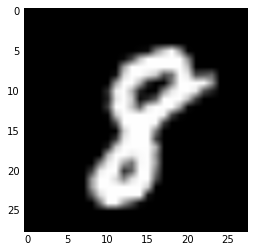

8

In [87]:
mle_model = mle_multivariate_gaussian_train(X, Y)
mle_multivariate_gaussian_predict(X[9323], mle_model, display=True)

### K Nearest Neighbor

In [2]:
def calculate_distances(x, X, metric):
    if metric=='L1':
        return np.array(np.sum(np.abs(X-x),axis=1)).ravel()
    elif metric=='L2':
        return linalg.norm(X-x,axis=1)
    elif metric=='L_inf':
        return np.array(np.max(np.abs(X-x),axis=1)).ravel()
    else:
        raise

def k_nearest_neighbour_predict(x, X, Y, metric, k, display=False):
    if display:
        pixels = np.array(x, dtype='uint8')
        pixels = pixels.reshape((28, 28))
        plt.imshow(pixels, cmap='gray')
        plt.show()
    distance = calculate_distances(x, X, metric)
    sorted_points = np.argsort(distance)
    if type(k) is list: #this is to avoid recomputing the distances
        result_set = {}
        for i in k:
            k_nearest = Y[sorted_points][1:i+1]
            plurality = stats.mode(k_nearest)[0][0][0]
            result_set[i]=plurality
        return result_set
    else:
        k_nearest = Y[sorted_points][1:k+1]
        plurality = stats.mode(k_nearest)[0][0][0]
        return plurality

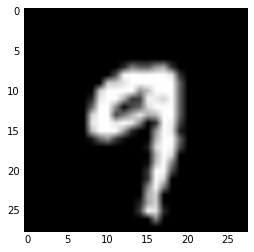

9

In [3]:
k_nearest_neighbour_predict(X[0], X, Y, 'L_inf', 3, display=True)

# Performance Evaluation

In [373]:
mle_error_rate = {}
knn_error_rate = {}

for train_size in [20, 50, 100, 200, 500, 1000, 2000, 5000, 'ALL']:
    if train_size == 'ALL':
        x_train = x_test = X
        y_train = y_test = Y
    else: #evaluate training set error itself
        x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=train_size, stratify=Y)
    
    mle_model = mle_multivariate_gaussian_train(x_train, y_train)
    mle_error_count = 0
    for x,y in zip(x_test,y_test.ravel()):
        y_hat = mle_multivariate_gaussian_predict(x, mle_model)
        if y_hat != y:
            mle_error_count += 1
    mle_error_rate['mle_trainsize_{}'.format(train_size)] = mle_error_count/len(y_test)

    """
    k = [1,3,5,7,9]
    for metric in ['L1','L2','L_inf']:
        knn_error_count = defaultdict(int)
        for x,y in zip(x_test, y_test.ravel()):
            y_hat = k_nearest_neighbour_predict(x, x_train, y_train, metric, k)
            for i in k:
                if y_hat[i] != y:
                    knn_error_count[i] += 1
        for i in k:
            knn_error_rate['{}nn_{}_trainsize_{}'.format(i, metric, train_size)] = knn_error_count[i]/len(y_test)
    """

In [6]:
mle_error_rate

{'mle_trainsize_100': 0.2237147762852237,
 'mle_trainsize_1000': 0.08133333333333333,
 'mle_trainsize_20': 0.4304609218436874,
 'mle_trainsize_200': 0.1416326530612245,
 'mle_trainsize_2000': 0.118375,
 'mle_trainsize_50': 0.334707005729219,
 'mle_trainsize_500': 0.0903062835491001,
 'mle_trainsize_5000': 0.2632,
 'mle_trainsize_ALL': 0.0278}

In [7]:
knn_error_rate

{'1nn_L1_trainsize_100': 0.41026158973841026,
 '1nn_L1_trainsize_1000': 0.168,
 '1nn_L1_trainsize_20': 0.6248496993987976,
 '1nn_L1_trainsize_200': 0.31255102040816324,
 '1nn_L1_trainsize_2000': 0.137875,
 '1nn_L1_trainsize_50': 0.5054779374811539,
 '1nn_L1_trainsize_500': 0.2228186506683507,
 '1nn_L1_trainsize_5000': 0.0986,
 '1nn_L1_trainsize_ALL': 0.0559,
 '1nn_L2_trainsize_100': 0.39824260175739823,
 '1nn_L2_trainsize_1000': 0.15433333333333332,
 '1nn_L2_trainsize_20': 0.6160320641282565,
 '1nn_L2_trainsize_200': 0.29928571428571427,
 '1nn_L2_trainsize_2000': 0.11725,
 '1nn_L2_trainsize_50': 0.48949643180219116,
 '1nn_L2_trainsize_500': 0.20808335964635302,
 '1nn_L2_trainsize_5000': 0.0898,
 '1nn_L2_trainsize_ALL': 0.0475,
 '1nn_L_inf_trainsize_100': 0.7428542571457428,
 '1nn_L_inf_trainsize_1000': 0.5885555555555556,
 '1nn_L_inf_trainsize_20': 0.8370741482965932,
 '1nn_L_inf_trainsize_200': 0.7094897959183674,
 '1nn_L_inf_trainsize_2000': 0.499,
 '1nn_L_inf_trainsize_50': 0.816363

In [9]:
mle = pd.DataFrame.from_dict(mle_error_rate, 'index').reset_index()
mle = mle.rename(columns={0:'MLE'})
mle['TrainSize'] = mle['index'].map(lambda x: int(x.split('_')[-1]) if x.split('_')[-1] != 'ALL' else 10000)
mle = mle.drop('index',axis=1)

In [10]:
knn = pd.DataFrame.from_dict(knn_error_rate, 'index').reset_index()
knn['TrainSize'] = knn['index'].map(lambda x: int(x.split('_')[-1]) if x.split('_')[-1] != 'ALL' else 10000)
knn['Classifier'] = knn['index'].map(lambda x: x.split('_')[0])
knn['DistanceMetric'] = knn['index'].map(lambda x: 'L_inf' if 'L_inf' in x else x.split('_')[1])
knn = knn.drop('index',axis=1)

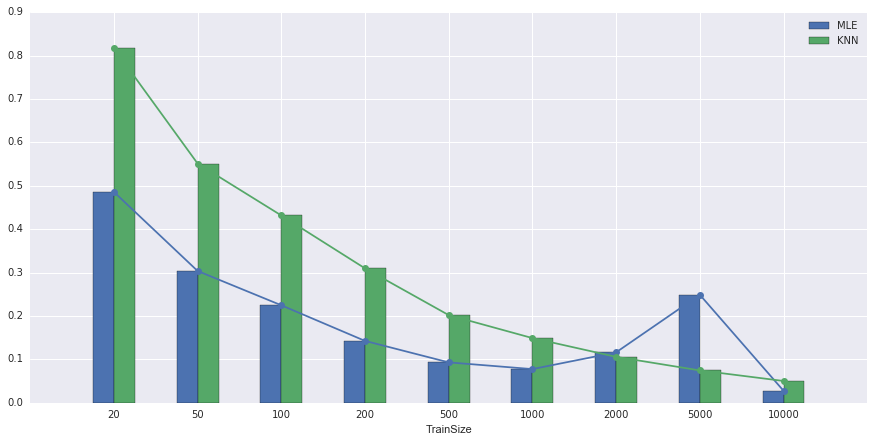

In [336]:
knn5_L2 = knn[(knn['Classifier']=='5nn') & (knn['DistanceMetric']=='L2') ]\
.drop(['Classifier','DistanceMetric'],axis=1).rename(columns={0:'KNN'})
knn5_L2
mle_knn = mle.sort_values('TrainSize').merge(knn5_L2, how='left')
mle_knn['TrainSize'] = mle_knn['TrainSize'].astype(str)
mle_knn = mle_knn.set_index('TrainSize')

ax = mle_knn.plot( kind='bar',figsize=(15,7))
mle_knn.plot(linestyle='-', marker='o', ax=ax, legend=False)
ax.set_xticklabels(mle_knn.index)
ax.set_xlim(ax.get_xlim()[0] - 1, ax.get_xlim()[1] + 1)
plt.show()

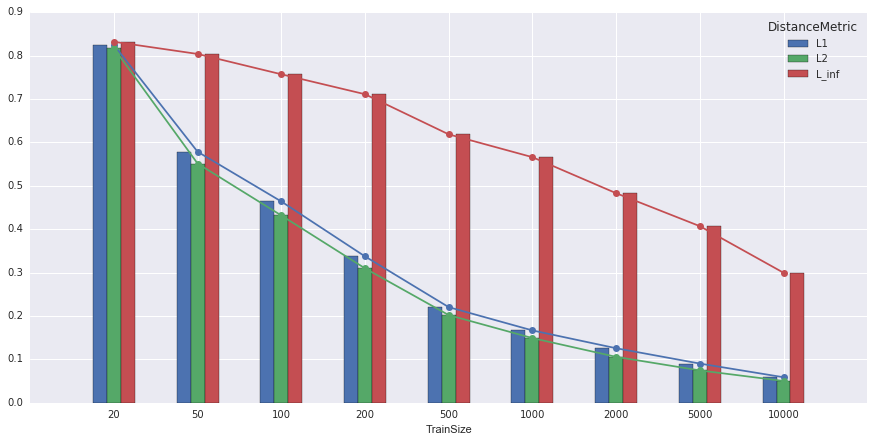

In [13]:
knn5 = knn[(knn['Classifier']=='5nn') ].drop(['Classifier'],axis=1).rename(columns={0:'KNN'})
knn5 = knn5.pivot_table(values='KNN',index='TrainSize',columns='DistanceMetric')
knn5 = knn5.sort_index()
knn5.index = knn5.index.astype(str)
knn5

ax = knn5.plot( kind='bar',figsize=(15,7))
knn5.plot(linestyle='-', marker='o', ax=ax, legend=False)
ax.set_xticklabels(knn5.index)
ax.set_xlim(ax.get_xlim()[0] - 1, ax.get_xlim()[1] + 1)
plt.show()

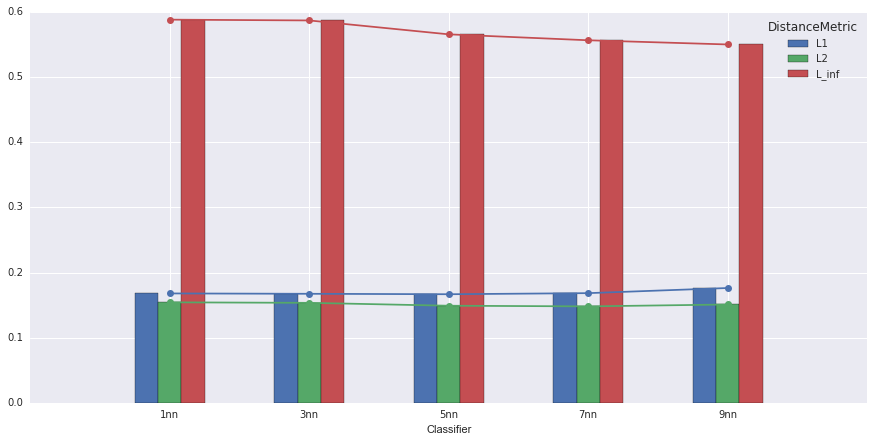

In [14]:
knn5 = knn[(knn['TrainSize']==1000) ].drop(['TrainSize'],axis=1).rename(columns={0:'KNN'})
knn5 = knn5.pivot_table(values='KNN',index='Classifier',columns='DistanceMetric')
knn5 = knn5.sort_index()
knn5

ax = knn5.plot( kind='bar',figsize=(15,7))
knn5.plot(linestyle='-', marker='o', ax=ax, legend=False)
ax.set_xticklabels(knn5.index)
ax.set_xlim(ax.get_xlim()[0] - 1, ax.get_xlim()[1] + 1)
plt.show()

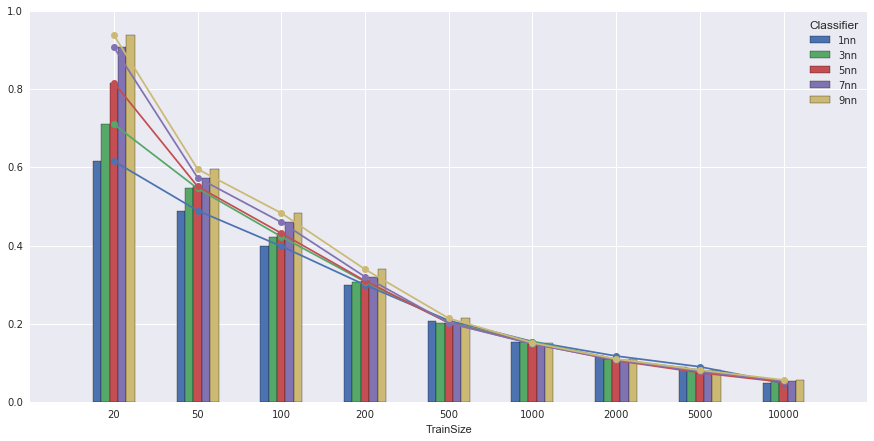

In [335]:
knn_L2 = knn[(knn['DistanceMetric']=='L2') ].drop(['DistanceMetric'],axis=1).rename(columns={0:'KNN'})
knn_L2 = knn_L2.pivot_table(values='KNN',index='TrainSize',columns='Classifier')
knn_L2 = knn_L2.sort_index()
knn_L2.index = knn_L2.index.astype(str)
knn_L2

ax = knn_L2.plot( kind='bar',figsize=(15,7))
knn_L2.plot(linestyle='-', marker='o', ax=ax, legend=False)
ax.set_xticklabels(knn_L2.index)
ax.set_xlim(ax.get_xlim()[0] - 1, ax.get_xlim()[1] + 1)
plt.show()

## Strengths in recognizing different numbers

In [363]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=2000, stratify=Y)

mle_model = mle_multivariate_gaussian_train(x_train, y_train)
mle_Y_predict = []
for x,y in zip(x_test,y_test.ravel()):
    y_hat = mle_multivariate_gaussian_predict(x, mle_model)
    mle_Y_predict.append(y_hat)
    
knn_Y_predict = []
for x,y in zip(x_test,y_test.ravel()):
    y_hat = k_nearest_neighbour_predict(x, x_train, y_train, 'L2', 5)
    knn_Y_predict.append(y_hat)

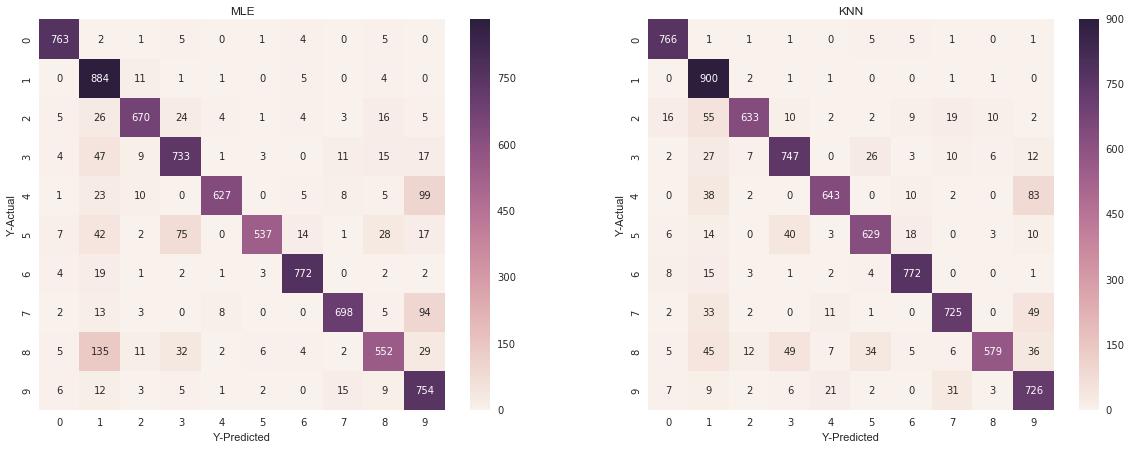

In [371]:
fig, axs = plt.subplots(ncols=2, figsize = (20,7))

mle_confusion_df = pd.DataFrame(index=range(0,10), columns=range(0,10)).fillna(0)
for answer,predict in zip(y_test.ravel(), mle_Y_predict):
    mle_confusion_df.loc[answer,predict] = mle_confusion_df.loc[answer,predict] + 1
mle_cm = pd.DataFrame(mle_confusion_df, index = [i for i in range(0,10)], columns = [i for i in range(0,10)])
mle_cm.index.name = 'Y-Actual'
mle_cm.columns.name = 'Y-Predicted'
sn.heatmap(mle_cm, annot=True, fmt="d", ax=axs[0]).set_title('MLE')

knn_confusion_df = pd.DataFrame(index=range(0,10), columns=range(0,10)).fillna(0)
for answer,predict in zip(y_test.ravel(), knn_Y_predict):
    knn_confusion_df.loc[answer,predict] = knn_confusion_df.loc[answer,predict] + 1
knn_cm = pd.DataFrame(knn_confusion_df, index = [i for i in range(0,10)], columns = [i for i in range(0,10)])
knn_cm.index.name = 'Y-Actual'
knn_cm.columns.name = 'Y-Predicted'
sn.heatmap(knn_cm, annot=True, fmt="d", ax=axs[1]).set_title('KNN')